# COMT - Single gene analysis in the NBA GP2 data


- Project: COMT Single Gene analysis
- Version: Python/3.10.12; R 4.4.2
- Last Updated: 01-APRIL-2025
- Update Description: Clean code and adding some minor comments

## Notebook overview
- In this notebook we performed association analysis with PLINK using COMT gene variants data in NBA data. We used a loop to perform the same analysis across different GP2 population ancestries.
- GP2 NBA Data from Release 7 were used.


## Description

__1. Description__

-  Getting Started
- Loading Python libraries
- Defining functions
- Set Paths
- Make working directory

__2. Installing packages__

__3. Copy over data__

__4. Create a covariate file with GP2 data__

__5. Remove related individuals and PCA__

__6. Annotation of the gene__

__7. Case/Control Analyses__

__8. Clinical Data Analyses__


## Loading Python libraries

In [9]:
# Use the os package to interact with the environment
import os

# Bring in Pandas for Dataframe functionality
import pandas as pd

# Numpy for basics
import numpy as np

# Use StringIO for working with file contents
from io import StringIO

# Enable IPython to display matplotlib graphs
import matplotlib.pyplot as plt
%matplotlib inline

# Enable interaction with the FireCloud API
from firecloud import api as fapi

# Import the iPython HTML rendering for displaying links to Google Cloud Console
from IPython.core.display import display, HTML

# Import urllib modules for building URLs to Google Cloud Console
import urllib.parse

# BigQuery for querying data
from google.cloud import bigquery

#Import Sys
import sys as sys

/tmp/ipykernel_81/1504764740.py:21: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## Defining functions

In [10]:
# Utility routine for printing a shell command before executing it
def shell_do(command):
    print(f'Executing: {command}', file=sys.stderr)
    !$command
    
def shell_return(command):
    print(f'Executing: {command}', file=sys.stderr)
    output = !$command
    return '\n'.join(output)

# Utility routine for printing a query before executing it
def bq_query(query):
    print(f'Executing: {query}', file=sys.stderr)
    return pd.read_gbq(query, project_id=BILLING_PROJECT_ID, dialect='standard')

# Utility routine for display a message and a link
def display_html_link(description, link_text, url):
    html = f'''
    <p>
    </p>
    <p>
    {description}
    <a target=_blank href="{url}">{link_text}</a>.
    </p>
    '''

    display(HTML(html))

# Utility routines for reading files from Google Cloud Storage
def gcs_read_file(path):
    """Return the contents of a file in GCS"""
    contents = !gsutil -u {BILLING_PROJECT_ID} cat {path}
    return '\n'.join(contents)
    
def gcs_read_csv(path, sep=None):
    """Return a DataFrame from the contents of a delimited file in GCS"""
    return pd.read_csv(StringIO(gcs_read_file(path)), sep=sep, engine='python')

# Utility routine for displaying a message and link to Cloud Console
def link_to_cloud_console_gcs(description, link_text, gcs_path):
    url = '{}?{}'.format(
        os.path.join('https://console.cloud.google.com/storage/browser',
                     gcs_path.replace("gs://","")),
        urllib.parse.urlencode({'userProject': BILLING_PROJECT_ID}))

    display_html_link(description, link_text, url)

## Set paths

In [ ]:
# Set up billing project and data path variables
BILLING_PROJECT_ID = os.environ['GOOGLE_PROJECT']
WORKSPACE_NAMESPACE = os.environ['WORKSPACE_NAMESPACE']
WORKSPACE_NAME = os.environ['WORKSPACE_NAME']
WORKSPACE_BUCKET = os.environ['WORKSPACE_BUCKET']

WORKSPACE_ATTRIBUTES = fapi.get_workspace(WORKSPACE_NAMESPACE, WORKSPACE_NAME).json().get('workspace',{}).get('attributes',{})

## GP2 v7.0
GP2_RELEASE_PATH = 'path/'
GP2_CLINICAL_RELEASE_PATH = f'{GP2_RELEASE_PATH}/clinical_data'
GP2_META_RELEASE_PATH = f'{GP2_RELEASE_PATH}/meta_data'
GP2_SUMSTAT_RELEASE_PATH = f'{GP2_RELEASE_PATH}/summary_statistics'

GP2_RAW_GENO_PATH = f'{GP2_RELEASE_PATH}/raw_genotypes'
GP2_IMPUTED_GENO_PATH = f'{GP2_RELEASE_PATH}/imputed_genotypes'
print('GP2 v7.0')
print(f'Path to GP2 v7.0 Clinical Data: {GP2_CLINICAL_RELEASE_PATH}')
print(f'Path to GP2 v7.0 Raw Genotype Data: {GP2_RAW_GENO_PATH}')
print(f'Path to GP2 v7.0 Imputed Genotype Data: {GP2_IMPUTED_GENO_PATH}')

## Make working directory

In [12]:
# Let's create a single folder for all the files
WORK_DIR = f'/home/jupyter/COMT_NBA_loop/'
shell_do(f'mkdir -p {WORK_DIR}') 

Executing: mkdir -p /home/jupyter/COMT_NBA_loop/


# Install Packages

## PLINK

In [15]:
%%bash

mkdir -p ~/tools
cd ~/tools

if test -e /home/jupyter/tools/plink; then
echo "Plink1.9 is already installed in /home/jupyter/tools/"

else
echo -e "Downloading plink \n    -------"
wget -N http://s3.amazonaws.com/plink1-assets/plink_linux_x86_64_20190304.zip 
unzip -o plink_linux_x86_64_20190304.zip
echo -e "\n plink downloaded and unzipped in /home/jupyter/tools \n "

fi

Plink1.9 is already installed in /home/jupyter/tools/


Install plink2. If this doesn't work, get the updated download link from https://www.cog-genomics.org/plink/2.0/, as this changes regularly. We use the download link for Linux AVX2 AMD.

In [16]:
%%bash

mkdir -p ~/tools
cd ~/tools

if test -e /home/jupyter/tools/plink2; then
echo "Plink2 is already installed in /home/jupyter/tools/"

else
echo -e "Downloading plink2 \n    -------"
wget -N https://s3.amazonaws.com/plink2-assets/plink2_linux_amd_avx2_20240806.zip
unzip -o plink2_linux_amd_avx2_20240806.zip
echo -e "\n plink2 downloaded and unzipped in /home/jupyter/tools \n "

fi

Plink2 is already installed in /home/jupyter/tools/


## ANNOVAR

In [14]:
%%capture
%%bash

# https://www.openbioinformatics.org/annovar/annovar_download_form.php

if test -e /home/jupyter/tools/annovar; then

echo "annovar is already installed in /home/jupyter/tools/"
else
echo "annovar is not installed"
cd /home/jupyter/tools/

wget http://www.openbioinformatics.org/annovar/download/0wgxR2rIVP/annovar.latest.tar.gz

tar xvfz annovar.latest.tar.gz

fi

### ANNOVAR: Download sources of annotation


In [22]:
%%bash

cd /home/jupyter/tools/annovar/

perl annotate_variation.pl -buildver hg38 -downdb -webfrom annovar refGene humandb/
perl annotate_variation.pl -buildver hg38 -downdb -webfrom annovar clinvar_20170905 humandb/

## RVTests

In [18]:
%%bash

#Install RVTESTS: Option 1 (~15min)
if test -e /home/jupyter/tools/rvtests; then

echo "rvtests is already installed"
else
echo "rvtests is not installed"

mkdir /home/jupyter/tools/rvtests
cd /home/jupyter/tools/rvtests

wget https://github.com/zhanxw/rvtests/releases/download/v2.1.0/rvtests_linux64.tar.gz 

tar -zxvf rvtests_linux64.tar.gz
fi

rvtests is already installed


In [19]:
# chmod to make sure you have permission to run the program
! chmod u+x /home/jupyter/tools/plink
! chmod u+x /home/jupyter/tools/plink2
! chmod 777 /home/jupyter/tools/rvtests/executable/rvtest

In [20]:
%%bash

#Show installed tools
ls /home/jupyter/tools/

annovar
annovar.latest.tar.gz
LICENSE
plink
plink2
plink2_linux_amd_avx2_20250129.zip
plink_linux_x86_64_20190304.zip
prettify
rvtests
toy.map
toy.ped
vcf_subset


# Copy Over Files 

In [ ]:
# Download clinical data
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/clinical_data/master_key_release7_final.csv {WORK_DIR}')
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/clinical_data/extended_clinical_data_release7.csv {WORK_DIR}/')

# Create a covariate file with GP2 data

In [5]:
# Let's load the master key
FULL_PATH = WORK_DIR + f'master_key_release7_final.csv'
key = pd.read_csv(FULL_PATH, low_memory=False)
print(f'Clinical data (num rows, num columns): {key.shape}')
pd.set_option('display.max_columns', None)


Clinical data (num rows, num columns): (44281, 26)


In [6]:
# Subsetting to keep only a few columns 
key = key[['GP2sampleID', 'baseline_GP2_phenotype_for_qc', 'biological_sex_for_qc', 'age_at_sample_collection', 'age_of_onset', 'label','GP2ID']]
# Renaming the columns
key.rename(columns = {'GP2sampleID':'IID',
                                     'baseline_GP2_phenotype_for_qc':'phenotype',
                                     'biological_sex_for_qc':'SEX', 
                                     'age_at_sample_collection':'AGE', 
                                     'age_of_onset':'AAO'}, inplace = True)


In [ ]:
# For each ancestry, we download related samples, and genotyping imputed data.
ancestries = {'AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH'}

for ancestry in ancestries:
    shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_META_RELEASE_PATH}/related_samples/{ancestry}_release7.related {WORK_DIR}')
    shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/raw_genotypes/{ancestry}/{ancestry}_release7.eigenvec {WORK_DIR}')
    shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/raw_genotypes/{ancestry}/{ancestry}_release7* {WORK_DIR}')
    shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {GP2_RELEASE_PATH}/imputed_genotypes/{ancestry}/chr22* {WORK_DIR}')


In [ ]:
ancestries = {'AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH'}

for ancestry in ancestries:
    
    print(f'WORKING ON: {ancestry}')
    
    ## Subset to keep ancestry of interest 
    ancestry_key = key[key['label']==ancestry].copy()
    ancestry_key.reset_index(drop=True)
    print(ancestry_key.shape)
    # Load information about related individuals in the ancestry analyzed
    related_df = pd.read_csv(f'{WORK_DIR}/{ancestry}_release7.related')
    print(f'Related individuals: {related_df.shape}')

    # Make a list of just one set of related people
    related_list = list(related_df['IID1'])

    # Check value counts of related and remove only one related individual
    ancestry_key = ancestry_key[~ancestry_key["IID"].isin(related_list)]

    # Check size
    print(f'Unrelated individuals: {ancestry_key.shape}')
    
    # Convert phenotype to binary (1/2)
    ## Assign conditions so case=2 and controls=1, and -9 otherwise (matching PLINK convention)
    # PD = 2; control = 1
    pheno_mapping = {"PD": 2, "Control": 1}
    ancestry_key['PHENO'] = ancestry_key['phenotype'].map(pheno_mapping).astype('Int64')

    # Check value counts of pheno
    ancestry_key['PHENO'].value_counts(dropna=False)
    
    ## Get the PCs
    pcs = pd.read_csv(f'{WORK_DIR}/{ancestry}_release7.eigenvec', sep='\t')
    
    #Select just first 5 PCs
    selected_columns = ['IID', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5']
    pcs = pd.DataFrame(data=pcs.iloc[:, 1:7].values, columns=selected_columns)

    # Reset the index to remove any potential issues
    pcs = pcs.reset_index(drop=True)
    
    # Check size
    print(f'PCs: {pcs.shape}')

    # Check value counts of SEX
    sex_og_values = ancestry_key['SEX'].value_counts(dropna=False)
    print(f'Sex value counts - original:\n {sex_og_values.to_string()}')
    
    # Convert sex to binary (1/2)
    ## Assign conditions so female=2 and men=1, and -9 otherwise (matching PLINK convention)
    # Female = 2; Male = 1
    sex_mapping = {"Female": 2, "Male": 1}
    ancestry_key['SEX'] = ancestry_key['SEX'].map(sex_mapping).astype('Int64')
    
    # Check value counts of SEX after recoding
    sex_recode_values = ancestry_key['SEX'].value_counts(dropna=False)
    print(f'Sex value counts - recoded:\n{sex_recode_values.to_string()}')
    
    ## Make covariate file
    df = pd.merge(pcs, ancestry_key, on='IID')
    print(f'Check columns for covariate file: {df.columns}')
    
    #Make additional columns - FID, fatid and matid - these are needed for RVtests!!
    #RVtests needs the first 5 columns to be fid, iid, fatid, matid and sex otherwise it does not run correctly
    #Uppercase column name is ok
    #See https://zhanxw.github.io/rvtests/#phenotype-file
    df['FID'] = 0
    df['FATID'] = 0
    df['MATID'] = 0

    ## Clean up and keep columns we need 
    final_df = df[['FID','IID', 'FATID', 'MATID', 'SEX', 'AGE', 'PHENO','PC1', 'PC2', 'PC3', 'PC4', 'PC5','GP2ID']].copy()

    ##DO NOT replace missing values with -9 as this is misinterpreted by RVtests - needs to be nonnumeric
    #Leave missing values as NA
    
    #Check number of PD cases missing age
    pd_missAge = final_df[(final_df['PHENO']==2)&(final_df['AGE'].isna())]
    print(f'Number of PD cases missing age: {pd_missAge.shape[0]}')
    
    #Check number of controls missing age
    control_missAge = final_df[(final_df['PHENO']==1)&(final_df['AGE'].isna())]
    print(f'Number of controls missing age: {control_missAge.shape[0]}')

    ## Make file of sample IDs to keep 
    samples_toKeep = final_df[['FID', 'IID']].copy()
    samples_toKeep.to_csv(f'{WORK_DIR}/samplestokeep_{ancestry}.txt', sep="\t",index=None)
    
    final_df.to_csv(f'{WORK_DIR}/{ancestry}_covariate_file.txt', sep = '\t', na_rep='NA', index=False)


# Annotation of the gene


- COMT coordinates: chr22: 19,941,371-19,969,975 (GRCh38/hg38) (forward strand - ensemble)

## Extract the region using PLINK

In [11]:
## extract region using plink for each ancestry
for ancestry in ancestries:

    ! /home/jupyter/plink2 \
    --pfile {WORK_DIR}/chr22_{ancestry}_release7 \
    --chr 22 \
    --from-bp 19941371 \
    --to-bp 19969975 \
    --keep {WORK_DIR}/samplestokeep_{ancestry}.txt \
    --max-alleles 2 \
    --mac 2 \
    --make-bed \
    --out {WORK_DIR}/{ancestry}_COMT

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//AMR_COMT.log.
Options in effect:
  --chr 22
  --from-bp 19941371
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_AMR.txt
  --mac 2
  --make-bed
  --max-alleles 2
  --out /home/jupyter/COMT_NBA_loop//AMR_COMT
  --pfile /home/jupyter/COMT_NBA_loop//chr22_AMR_release7
  --to-bp 19969975

Start time: Fri Mar 14 16:45:58 2025
7445 MiB RAM detected, ~5619 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
614 samples (271 females, 343 males; 614 founders) loaded from
/home/jupyter/COMT_NBA_loop//chr22_AMR_release7.psam.
465193 variants loaded from
/home/jupyter/COMT_NBA_loop//chr22_AMR_release7.pvar.
1 binary phenotype loaded (431 cases, 150 controls).
--keep: 609 samples remaining.
609 samples (268 females, 341 males; 609 founders) remaining after main
filters.
4

Calculating allele frequencies... done.
258 variants removed due to allele frequency threshold(s)
(--maf/--max-maf/--mac/--max-mac).
366 variants remaining after main filters.
Writing /home/jupyter/COMT_NBA_loop//CAH_COMT.fam ... done.
Writing /home/jupyter/COMT_NBA_loop//CAH_COMT.bim ... done.
Writing /home/jupyter/COMT_NBA_loop//CAH_COMT.bed ... done.
End time: Fri Mar 14 16:46:09 2025
PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//AAC_COMT.log.
Options in effect:
  --chr 22
  --from-bp 19941371
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_AAC.txt
  --mac 2
  --make-bed
  --max-alleles 2
  --out /home/jupyter/COMT_NBA_loop//AAC_COMT
  --pfile /home/jupyter/COMT_NBA_loop//chr22_AAC_release7
  --to-bp 19969975

Start time: Fri Mar 14 16:46:10 2025
7445 MiB RAM detected, ~5609 available; reserving 3722 MiB for main workspace.
Using

## Turn binary files into VCF

In [12]:
for ancestry in ancestries:
        
    ## Turn binary files into VCF
    ! /home/jupyter/plink2 \
    --bfile {WORK_DIR}/{ancestry}_COMT \
    --recode vcf id-paste=iid \
    --out {WORK_DIR}/{ancestry}_COMT

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//AMR_COMT.log.
Options in effect:
  --bfile /home/jupyter/COMT_NBA_loop//AMR_COMT
  --export vcf id-paste=iid
  --out /home/jupyter/COMT_NBA_loop//AMR_COMT

Start time: Fri Mar 14 16:46:21 2025
7445 MiB RAM detected, ~5613 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
609 samples (268 females, 341 males; 609 founders) loaded from
/home/jupyter/COMT_NBA_loop//AMR_COMT.fam.
249 variants loaded from /home/jupyter/COMT_NBA_loop//AMR_COMT.bim.
1 binary phenotype loaded (427 cases, 150 controls).
--export vcf to /home/jupyter/COMT_NBA_loop//AMR_COMT.vcf ... 101011111212131314141515161617171818191920202121222223232424252526262727282829293030313132323333343435353636373738383939404041414242434344444545464647474848494950505151525253535454555556565757585859596060616162

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//EUR_COMT.log.
Options in effect:
  --bfile /home/jupyter/COMT_NBA_loop//EUR_COMT
  --export vcf id-paste=iid
  --out /home/jupyter/COMT_NBA_loop//EUR_COMT

Start time: Fri Mar 14 16:46:29 2025
7445 MiB RAM detected, ~5621 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
25309 samples (9886 females, 15423 males; 25309 founders) loaded from
/home/jupyter/COMT_NBA_loop//EUR_COMT.fam.
994 variants loaded from /home/jupyter/COMT_NBA_loop//EUR_COMT.bim.
1 binary phenotype loaded (13034 cases, 5191 controls).
--export vcf to /home/jupyter/COMT_NBA_loop//EUR_COMT.vcf ... 10101111121213131414151516161717181819192020212122222323242425252626272728282929303031313232333334343535363637373838393940404141424243434444454546464747484849505051515252535354545555565657575858595960

In [13]:
### Bgzip and Tabix (zip and index the file)
for ancestry in ancestries:    
    ! bgzip -f {WORK_DIR}/{ancestry}_COMT.vcf
    ! tabix -f -p vcf {WORK_DIR}/{ancestry}_COMT.vcf.gz 

## Annotate using ANNOVAR

In [ ]:
for ancestry in ancestries:
        
    ! perl /home/jupyter/tools/annovar/table_annovar.pl {WORK_DIR}/{ancestry}_COMT.vcf.gz /home/jupyter/tools/annovar/humandb/ -buildver hg38 \
    -out {WORK_DIR}/{ancestry}_COMT.annovar \
    -remove -protocol refGene,clinvar_20170905 \
    -operation g,f \
    --nopolish \
    -nastring . \
    -vcfinput
    

In [ ]:
ancestries = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH']

for ancestry in ancestries:
        
    print(f'WORKING ON: {ancestry}')
    
    # Read in ANNOVAR multianno file
    gene = pd.read_csv(f'{WORK_DIR}/{ancestry}_COMT.annovar.hg38_multianno.txt', sep = '\t')
    
    #Filter for the correct gene name (sometimes other genes are also included)
    gene = gene[gene['Gene.refGene'] == 'COMT']
    
    #Print number of variants in the different categories
    results = [] 

    intronic = gene[gene['Func.refGene']== 'intronic']
    upstream = gene[gene['Func.refGene']== 'upstream']
    downstream = gene[gene['Func.refGene']== 'downstream']
    utr5 = gene[gene['Func.refGene']== 'UTR5']
    utr3 = gene[gene['Func.refGene']== 'UTR3']
    splicing = gene[gene['Func.refGene']== 'splicing']
    exonic = gene[gene['Func.refGene']== 'exonic']
    stopgain = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'stopgain')]
    stoploss = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'stoploss')]
    startloss = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'startloss')]
    frameshift_deletion = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'frameshift deletion')]
    frameshift_insertion = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'frameshift insertion')]
    nonframeshift_deletion = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'nonframeshift deletion')]
    nonframeshift_insertion = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'nonframeshift insertion')]
    coding_nonsynonymous = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'nonsynonymous SNV')]
    coding_synonymous = gene[(gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] == 'synonymous SNV')]
        
    print({ancestry})
    print('Total variants: ', len(gene))
    print("Intronic: ", len(intronic))
    print("Upstream: ", len(upstream))
    print("Downstream: ", len(downstream))
    print('UTR3: ', len(utr3))
    print('UTR5: ', len(utr5))
    print("Splicing: ", len(splicing))
    print("Total exonic: ", len(exonic))
    print("Stopgain: ", len(stopgain))
    print("Stoploss: ", len(stoploss))
    print("Startloss: ", len(startloss))
    print("Frameshift deletion: ", len(frameshift_deletion))
    print("Frameshift insertion: ", len(frameshift_insertion))
    print("Non-frameshift insertion: ", len(nonframeshift_insertion))
    print("Non-frameshift deletion: ", len(nonframeshift_deletion))
    print('Synonymous: ', len(coding_synonymous))
    print("Nonsynonymous: ", len(coding_nonsynonymous))
    results.append((gene, intronic, upstream, downstream, utr3, utr5, splicing,exonic,stopgain,stoploss,startloss, frameshift_deletion,frameshift_insertion,nonframeshift_deletion,nonframeshift_insertion,coding_synonymous, coding_nonsynonymous))
    print('\n')
    
    ## For rvtests
    
    # Potential functional: These are variants annotated as frameshift, nonframeshift, startloss, stoploss, stopgain, splicing, missense, exonic, UTR5, UTR3, upstream (-100bp), downstream (+100bp), or ncRNA. 
    potentially_functional = gene[gene['Func.refGene'] != 'intronic']
    # Coding: These are variants annotated as frameshift, nonframeshift, startloss, stoploss, stopgain, splicing, or missense.
    coding_variants = gene[(gene['Func.refGene'] == 'splicing') | (gene['Func.refGene'] == 'exonic') & (gene['ExonicFunc.refGene'] != 'synonymous SNV')]
    # Loss of function: These are variants annotated as frameshift, startloss,stopgain, or splicing.
    loss_of_function = gene[(gene['Func.refGene'] == 'splicing') | (gene['ExonicFunc.refGene'] == 'stopgain') | (gene['ExonicFunc.refGene'] == 'startloss') | (gene['ExonicFunc.refGene'] == 'frameshift deletion') | (gene['ExonicFunc.refGene'] == 'frameshift insertion')]
    
    # Save in PLINK format
    variants_toKeep = potentially_functional[['Chr', 'Start', 'End', 'Gene.refGene']].copy()
    variants_toKeep.to_csv(f'{WORK_DIR}/{ancestry}_COMT.potentially_functional.variantstoKeep.txt', sep="\t", index=False, header=False)

    variants_toKeep2 = coding_variants[['Chr', 'Start', 'End', 'Gene.refGene']].copy()
    variants_toKeep2.to_csv(f'{WORK_DIR}/{ancestry}_COMT.coding_variants.variantstoKeep.txt', sep="\t", index=False, header=False)

    variants_toKeep3 = loss_of_function[['Chr', 'Start', 'End', 'Gene.refGene']].copy()
    variants_toKeep3.to_csv(f'{WORK_DIR}/{ancestry}_COMT.loss_of_function.variantstoKeep.txt', sep="\t", index=False, header=False)
    
    # These are all exonic variants
    exonic = gene[gene['Func.refGene'] == 'exonic']
    
    # Save in PLINK format
    variants_toKeep4 = exonic[['Chr', 'Start', 'End', 'Gene.refGene']].copy()
    variants_toKeep4.to_csv(f'{WORK_DIR}/{ancestry}_COMT.exonic.variantstoKeep.txt', sep="\t", index=False, header=False)

## Burden Analyses using RVTests

In [ ]:
ancestries = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH']
variant_classes = ['potentially_functional', 'coding_variants','loss_of_function']

#Loop over all the ancestries and the 3 variant classes
for ancestry in ancestries:
    for variant_class in variant_classes:
                
        # Print the command to be executed (for debugging purposes)
        print(f'Running plink to extract {variant_class} variants for ancestry: {ancestry}')
        
        #Extract relevant variants
        ! /home/jupyter/plink2 \
        --pfile {WORK_DIR}/chr22_{ancestry}_release7 \
        --keep {WORK_DIR}/samplestokeep_{ancestry}.txt \
        --extract range {WORK_DIR}/{ancestry}_COMT.{variant_class}.variantstoKeep.txt \
        --recode vcf-iid \
        --out {WORK_DIR}/{ancestry}_COMT.{variant_class}

        # Print the command to be executed (for debugging purposes)
        print(f'Running bgzip and tabix for {variant_class} variants for ancestry: {ancestry}')
        
        ## Bgzip and Tabix (zip and index the file)
        ! bgzip -f {WORK_DIR}/{ancestry}_COMT.{variant_class}.vcf
        ! tabix -f -p vcf {WORK_DIR}/{ancestry}_COMT.{variant_class}.vcf.gz

In [ ]:
shell_do(f'gsutil -u {BILLING_PROJECT_ID} -m cp {WORKSPACE_BUCKET}/refFlat.txt.gz {WORK_DIR}')


In [ ]:
!gzip -d -f {WORK_DIR}/refFlat.txt.gz


In [ ]:
#Run RVtests
ancestries = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH']
variant_classes = ['potentially_functional', 'coding_variants','loss_of_function']

for ancestry in ancestries:
    for variant_class in variant_classes:
                
        # Print the command to be executed (for debugging purposes)
        print(f'Running RVtests for {variant_class} variants for ancestry: {ancestry}')
        
        ## RVtests with covariates 
        #Make sure the pheno and covariate file starts with the first 5 columsn: fid, iid, fatid, matid, sex
        #The pheno-name flag only works when the pheno/covar file is structured properly
        ! /home/jupyter/tools/rvtests/executable/rvtest --noweb --hide-covar \
        --out {WORK_DIR}/{ancestry}_COMT.burden.{variant_class} \
        --kernel skat,skato \
        --inVcf {WORK_DIR}/{ancestry}_COMT.{variant_class}.vcf.gz \
        --pheno {WORK_DIR}/{ancestry}_covariate_file.txt \
        --pheno-name PHENO \
        --gene COMT \
        --geneFile {WORK_DIR}/refFlat.txt \
        --covar {WORK_DIR}/{ancestry}_covariate_file.txt \
        --covar-name SEX,AGE,PC1,PC2,PC3,PC4,PC5

In [ ]:
#Removed FIN and MDE from ancestry_GROUPS as there are no FIN samples and no variants of interest in MDE and CAH (only 4 samples)
ancestry_GROUPS = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'SAS']
#ancestry_GROUPS = ['CAH','MDE']
variant_classes = ['potentially_functional', 'coding_variants', 'loss_of_function']

for ancestry_GROUP in ancestry_GROUPS:
    for variant_class in variant_classes:
        
        shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/{ancestry_GROUP}_COMT.burden.{variant_class}.*.assoc {WORKSPACE_BUCKET}/COMT_NBA_loop/Burden/')

# Case/Control Analysis

__1. Glossary__
- CHR Chromosome code
- SNP Variant identifier
- A1 Allele 1 (usually minor)
- A2 Allele 2 (usually major)
- MAF Allele 1 frequency in all subjects
- F_A/MAF_A Allele 1 frequency in cases
- F_U/MAF_U Allele 1 frequency in controls
- NCHROBS_A Number of case allele observations
- NCHROBS_U Number of control allele observations



## All variants

### assoc

In [29]:
#Run case-control analysis using plink assoc for ALL variants, not adjusting for any covariates
ancestries = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH']

for ancestry in ancestries:

    
    ! /home/jupyter/plink1.9 \
    --bfile {WORK_DIR}/{ancestry}_COMT \
    --keep {WORK_DIR}/samplestokeep_{ancestry}.txt \
    --assoc \
    --maf 0.01 \
    --mac 2 \
    --hwe 0.0001 \
    --adjust \
    --allow-no-sex \
    --ci 0.95 \
    --out {WORK_DIR}/{ancestry}_COMT.AllVariants

    #--recode A creates a new text fileset, showing each variant in each case and control for the minor allele (A).
    ! /home/jupyter/plink1.9 \
    --bfile {WORK_DIR}/{ancestry}_COMT \
    --keep {WORK_DIR}/samplestokeep_{ancestry}.txt \
    --recode A \
    --out {WORK_DIR}/{ancestry}_COMT.AllVariants


PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//AAC_COMT.AllVariants.log.
Options in effect:
  --adjust
  --allow-no-sex
  --assoc
  --bfile /home/jupyter/COMT_NBA_loop//AAC_COMT
  --ci 0.95
  --hwe 0.0001
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_AAC.txt
  --mac 2
  --maf 0.01
  --out /home/jupyter/COMT_NBA_loop//AAC_COMT.AllVariants

7445 MB RAM detected; reserving 3722 MB for main workspace.
413 variants loaded from .bim file.
1097 people (450 males, 647 females) loaded from .fam.
1072 phenotype values loaded from .fam.
--keep: 1097 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 1097 founders and 0 nonfounders present.
Calculating allele frequencies... 101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//AJ_COMT.AllVariants.log.
Options in effect:
  --bfile /home/jupyter/COMT_NBA_loop//AJ_COMT
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_AJ.txt
  --out /home/jupyter/COMT_NBA_loop//AJ_COMT.AllVariants
  --recode A

7445 MB RAM detected; reserving 3722 MB for main workspace.
245 variants loaded from .bim file.
2454 people (1539 males, 915 females) loaded from .fam.
1625 phenotype values loaded from .fam.
--keep: 2454 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 2454 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genoty

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//EAS_COMT.AllVariants.log.
Options in effect:
  --bfile /home/jupyter/COMT_NBA_loop//EAS_COMT
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_EAS.txt
  --out /home/jupyter/COMT_NBA_loop//EAS_COMT.AllVariants
  --recode A

7445 MB RAM detected; reserving 3722 MB for main workspace.
420 variants loaded from .bim file.
4932 people (3128 males, 1804 females) loaded from .fam.
4892 phenotype values loaded from .fam.
--keep: 4932 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 4932 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total g

PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//SAS_COMT.AllVariants.log.
Options in effect:
  --adjust
  --allow-no-sex
  --assoc
  --bfile /home/jupyter/COMT_NBA_loop//SAS_COMT
  --ci 0.95
  --hwe 0.0001
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_SAS.txt
  --mac 2
  --maf 0.01
  --out /home/jupyter/COMT_NBA_loop//SAS_COMT.AllVariants

7445 MB RAM detected; reserving 3722 MB for main workspace.
203 variants loaded from .bim file.
539 people (351 males, 188 females) loaded from .fam.
517 phenotype values loaded from .fam.
--keep: 539 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 539 founders and 0 nonfounders present.
Calculating allele frequencies... 1011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071

### glm

In [120]:
#Run case-control analysis for all variants except introns, with covariates
#ancestries = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH']

# Add a0-ref flag to glm argument on selected ancestries to make sure all the ancestries test the same allele
ancestries_a0ref = ['EUR','AJ','MDE','SAS','CAH','CAS']

for ancestry in ancestries_a0ref:
    
    ! /home/jupyter/plink2 \
    --bfile {WORK_DIR}/{ancestry}_COMT \
    --keep {WORK_DIR}/samplestokeep_{ancestry}.txt \
    --glm a0-ref \
    --ci 0.95 \
    --mac 2 \
    --maf 0.01 \
    --hwe 0.0001 \
    --adjust \
    --covar {WORK_DIR}/{ancestry}_covariate_file.txt \
    --covar-name SEX,AGE,PC1,PC2,PC3,PC4,PC5 \
    --covar-variance-standardize \
    --out {WORK_DIR}/{ancestry}_COMT.AllVariants_a0ref # --out {WORK_DIR}/{ancestry}_COMT.AllVariants in case no a0-ref flag is needed
    
    #--recode A creates a new text fileset, showing each variant in each case and control for the minor allele (A). 
    ! /home/jupyter/plink1.9 \
    --bfile {WORK_DIR}/{ancestry}_COMT \
    --keep {WORK_DIR}/samplestokeep_{ancestry}.txt \
    --recode A \
    --out {WORK_DIR}/{ancestry}_COMT.AllVariants_a0ref
    

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//EUR_COMT.AllVariants_a0ref.log.
Options in effect:
  --adjust
  --bfile /home/jupyter/COMT_NBA_loop//EUR_COMT
  --ci 0.95
  --covar /home/jupyter/COMT_NBA_loop//EUR_covariate_file.txt
  --covar-name SEX,AGE,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm a0-ref
  --hwe 0.0001
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_EUR.txt
  --mac 2
  --maf 0.01
  --out /home/jupyter/COMT_NBA_loop//EUR_COMT.AllVariants_a0ref

Start time: Fri Mar 14 19:32:05 2025
7445 MiB RAM detected, ~5184 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
25309 samples (9886 females, 15423 males; 25309 founders) loaded from
/home/jupyter/COMT_NBA_loop//EUR_COMT.fam.
994 variants loaded from /home/jupyter/COMT_NBA_loop//EUR_COMT.bim.
1 binary phenotype loaded (13034 cases

In [ ]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/EUR_COMT.AllVariants_a0ref.PHENO1.glm.logistic.hybrid {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/')

In [ ]:
ancestry_GROUPS = ['AAC', 'AFR', 'AJ', 'CAS', 'EAS', 'EUR', 'SAS','CAH','MDE']

for ancestry_GROUP in ancestry_GROUPS:        
       shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/{ancestry_GROUP}_COMT.AllVariants.PHENO1.glm.logistic.hybrid.adjusted {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/bonf/')

In [38]:
ancestry_GROUPS = ['AAC', 'AFR', 'AJ', 'CAS', 'EAS', 'EUR', 'SAS','CAH','MDE']

for ancestry_GROUP in ancestry_GROUPS:        
       shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/{ancestry_GROUP}_COMT.AllVariants_a0ref.PHENO1.glm.logistic.hybrid.adjusted {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/bonf/')

In [117]:
#Process results from plink glm analysis for the variants
#ancestries = ['AAC', 'AFR', 'AJ', 'AMR', 'CAS', 'EAS', 'EUR', 'MDE', 'SAS', 'CAH']

# We process the results in two batches depending on if we have added a0-ref flag or not.
ancestries_a0ref = ['EUR','AJ','MDE','SAS','CAH','CAS']


for ancestry in ancestries_a0ref: # for ancestry in ancestries:
    
    print(f'WORKING ON: {ancestry}')
    
    #Read in glm results
    assoc = pd.read_csv(f'{WORK_DIR}/{ancestry}_COMT.AllVariants.PHENO1.glm.logistic.hybrid', delim_whitespace=True) # Change allExceptIntronic for allExceptIntronic_a0ref
    assoc_add = assoc[assoc['TEST']=="ADD"]
    
    #Filter for significant variants p < 0.05 - if any
    significant = assoc_add[assoc_add['P']<0.05]
    print(f'There are {len(significant)} variants with p-value < 0.05 in glm')
    
    #Read in plink recoded data (.raw file)
    recode = pd.read_csv(f'{WORK_DIR}/{ancestry}_COMT.AllVariants.raw', delim_whitespace=True)

    # Make a list from the column names
    column_names = recode.columns.tolist()

    # Drop the first 6 columns to keep the variants 
    variants = column_names[6:]

    print(f'Number of variants in {ancestry} for COMT: {len(variants)}')

    # Pre-filter the dataset
    cases_data = recode[recode['PHENOTYPE'] == 2]
    controls_data = recode[recode['PHENOTYPE'] == 1]

    results = []

    # Pre-filter the dataset
    total_cases = cases_data.shape[0]
    total_controls = controls_data.shape[0]
    results = []

    for variant in variants:
        ## For PD cases
        hom_cases = (cases_data[variant] == 2).sum()
        het_cases = (cases_data[variant] == 1).sum()
        hom_ref_cases = (cases_data[variant] == 0).sum()  # Homozygous reference genotype
        missing_cases = total_cases - (hom_cases + het_cases + hom_ref_cases)  # Missing data count
        freq_cases = (2 * hom_cases + het_cases) / (2 * (total_cases - missing_cases))  # Adjust for missing data in denominator

        ## For controls
        hom_controls = (controls_data[variant] == 2).sum()
        het_controls = (controls_data[variant] == 1).sum()
        hom_ref_controls = (controls_data[variant] == 0).sum()  # Homozygous reference genotype
        missing_controls = total_controls - (hom_controls + het_controls + hom_ref_controls)  # Missing data count
        freq_controls = (2 * hom_controls + het_controls) / (2 * (total_controls - missing_controls))  # Adjust for missing data in denominator
    
        # Append results in dictionary format
        results.append({
            'Variant': variant,
            'Hom Cases': hom_cases,
            'Het Cases': het_cases,
            'Hom Ref Cases': hom_ref_cases,
            'Missing Cases': missing_cases,
            'Total Cases': total_cases,
            'Carrier Freq in Cases': freq_cases,
            'Hom Controls': hom_controls,
            'Het Controls': het_controls,
            'Hom Ref Controls': hom_ref_controls,
            'Missing Controls': missing_controls,
            'Total Controls': total_controls,
            'Carrier Freq in Controls': freq_controls
        })

    # Return
    df_results = pd.DataFrame(results)
    df_results['ID'] = df_results['Variant'].apply(lambda x: x.rsplit('_', 1)[0])

    #Print dimensions of the df_results dataframe
    print(f'df_results shape: {df_results.shape}')
    
    #Merge with the glm file
    sig_merge = assoc_add[['ID','A1','A1_FREQ','OBS_CT','OR','LOG(OR)_SE','L95','U95','Z_STAT','P']]
    merged = pd.merge(df_results, sig_merge, on='ID', how='right')
    
    #Print dimensions of the merged dataframe (just adding more columns)
    print(f'Merged dataframe shape: {merged.shape}')
    ## Save to CSV
    merged.to_csv(f'{WORK_DIR}/{ancestry}.AllVariants_glm.txt', sep = '\t', index=False)

WORKING ON: AAC
There are 9 variants with p-value < 0.05 in glm
Number of variants in AAC for COMT: 413
df_results shape: (413, 14)
Merged dataframe shape: (186, 23)
WORKING ON: AFR
There are 1 variants with p-value < 0.05 in glm
Number of variants in AFR for COMT: 487
df_results shape: (487, 14)
Merged dataframe shape: (181, 23)
WORKING ON: AJ
There are 5 variants with p-value < 0.05 in glm
Number of variants in AJ for COMT: 245
df_results shape: (245, 14)
Merged dataframe shape: (128, 23)
WORKING ON: AMR
There are 13 variants with p-value < 0.05 in glm
Number of variants in AMR for COMT: 249
df_results shape: (249, 14)
Merged dataframe shape: (124, 23)
WORKING ON: CAS
There are 12 variants with p-value < 0.05 in glm
Number of variants in CAS for COMT: 229
df_results shape: (229, 14)
Merged dataframe shape: (121, 23)
WORKING ON: EAS
There are 3 variants with p-value < 0.05 in glm
Number of variants in EAS for COMT: 420
df_results shape: (420, 14)
Merged dataframe shape: (115, 23)
WORK

In [ ]:
ancestry_GROUPS = ['AAC', 'AFR', 'AJ', 'CAS', 'EAS', 'EUR', 'SAS','CAH','MDE']
ancestry_GROUPS = ['AMR']

for ancestry_GROUP in ancestry_GROUPS:        
        shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/{ancestry_GROUP}.AllVariants_glm.txt {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/')

In [ ]:
ancestries_a0ref = ['EUR','AJ','MDE','SAS','CAH','AMR','CAS']

for ancestry_GROUP in ancestries_a0ref:        
        shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/{ancestry_GROUP}.AllVariants_a0ref_glm.txt {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/a0ref/')

# Clinical Data Analyses

In [ ]:
# Read clinical data
full_clinic = pd.read_csv(f'{WORK_DIR}/extended_clinical_data_release7.csv')

## MOCA

In [43]:
# Create MOCA Dataset
moca=full_clinic[['GP2ID','visit_name','visit_month','last_diagnosis','moca_total_score','education_level','education_years','age_at_baseline']]
moca = moca.dropna(subset = ['moca_total_score'])
moca.shape

(2490, 8)

In [44]:
# Let's load the master key
FULL_PATH = WORK_DIR + f'master_key_release7_final.csv'
key = pd.read_csv(FULL_PATH, low_memory=False)
print(f'Clinical data (num rows, num columns): {key.shape}')
pd.set_option('display.max_columns', None)


Clinical data (num rows, num columns): (44281, 26)


In [45]:
key.columns

Index(['GP2ID', 'GP2sampleID', 'study', 'study_arm', 'study_type', 'diagnosis',
       'baseline_GP2_phenotype_for_qc', 'baseline_GP2_phenotype',
       'biological_sex_for_qc', 'age_at_sample_collection', 'age_of_onset',
       'age_at_diagnosis', 'age_at_death', 'age_at_last_follow_up',
       'race_for_qc', 'family_history_for_qc', 'region_for_qc', 'manifest_id',
       'Genotyping_site', 'sample_type', 'GDPR', 'monogenic', 'label',
       'pruned', 'pruned_reason', 'related'],
      dtype='object')

In [46]:
key = key[['GP2ID','GP2sampleID','label']]
key_EUR = key[key['label']=='EUR']


In [47]:
moca_ancestry = pd.merge(key_EUR,moca,on='GP2ID')
moca_ancestry['label'].value_counts()

label
EUR    1336
Name: count, dtype: int64

In [48]:
moca_ancestry['visit_month'].value_counts()

visit_month
0.0     1201
12.0     112
24.0      19
36.0       4
Name: count, dtype: int64

In [49]:
moca_ancestry_BL = moca_ancestry[moca_ancestry['visit_month']==0]
moca_ancestry_BL.shape


(1201, 10)

In [50]:
covar = pd.read_csv(f'{WORK_DIR}/EUR_covariate_file.txt',sep="\t")
covar_mocaBL=moca_ancestry_BL.merge(covar,on="GP2ID")


In [51]:
covar_mocaBL=covar_mocaBL[covar_mocaBL['PHENO']==2]
covar_mocaBL['PHENO'].value_counts()

PHENO
2.0    928
Name: count, dtype: int64

In [52]:
covar_mocaBL['education_level'].count()

595

In [53]:
covar_mocaBL['education_level'] = covar_mocaBL['education_level'].replace({'NaN': '-9'})
covar_mocaBL['education_level'] = covar_mocaBL['education_level'].replace({'High School/GED': '1'})
covar_mocaBL['education_level'] = covar_mocaBL['education_level'].replace({'<High School': '1'})
covar_mocaBL['education_level'] = covar_mocaBL['education_level'].replace({'Some college without degree': '2'})
covar_mocaBL['education_level'] = covar_mocaBL['education_level'].replace({"Bachelor's degree": '3'})
covar_mocaBL['education_level'] = covar_mocaBL['education_level'].replace({'Professional or doctoral degree': '4'})

In [54]:
covar_mocaBL_final = covar_mocaBL[['FID','IID','FATID','MATID','SEX','PHENO','visit_name','moca_total_score','age_at_baseline','education_level','PC1','PC2','PC3','PC4','PC5']]


In [55]:
covar_mocaBL_final = covar_mocaBL_final.drop_duplicates(subset=['IID'])

In [56]:
covar_mocaBL_final.to_csv(f'{WORK_DIR}/Covar_MOCA_BL_EUR.txt',sep=",",index=None)

In [57]:
!/home/jupyter/plink2 \
--bfile {WORK_DIR}/EUR_COMT \
--keep {WORK_DIR}/samplestokeep_EUR.txt \
--pheno {WORK_DIR}/Covar_MOCA_BL_EUR.txt \
--pheno-name moca_total_score \
--ci 0.95 \
--mac 2 \
--hwe 0.0001 \
--maf 0.01 \
--glm \
--adjust \
--covar {WORK_DIR}/Covar_MOCA_BL_EUR.txt \
--covar-name SEX,age_at_baseline,PC1,PC2,PC3,PC4,PC5,education_level \
--covar-variance-standardize \
--out {WORK_DIR}/COMT_GP2_EUR_MOCA

PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//COMT_GP2_EUR_MOCA.log.
Options in effect:
  --adjust
  --bfile /home/jupyter/COMT_NBA_loop//EUR_COMT
  --ci 0.95
  --covar /home/jupyter/COMT_NBA_loop//Covar_MOCA_BL_EUR.txt
  --covar-name SEX,age_at_baseline,PC1,PC2,PC3,PC4,PC5,education_level
  --covar-variance-standardize
  --glm
  --hwe 0.0001
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_EUR.txt
  --mac 2
  --maf 0.01
  --out /home/jupyter/COMT_NBA_loop//COMT_GP2_EUR_MOCA
  --pheno /home/jupyter/COMT_NBA_loop//Covar_MOCA_BL_EUR.txt
  --pheno-name moca_total_score

Start time: Fri Mar 28 16:53:52 2025
7445 MiB RAM detected, ~5793 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
25309 samples (9886 females, 15423 males; 25309 founders) loaded from
/home/jupyter/COMT_NBA_loop//EUR_COMT.fam.
994 variant

In [58]:
Moca_glm_add_AllVariants = pd.read_csv(f'{WORK_DIR}/COMT_GP2_EUR_MOCA.moca_total_score.glm.linear', delim_whitespace=True)
Moca_glm_add_AllVariants_add=Moca_glm_add_AllVariants[(Moca_glm_add_AllVariants['TEST']=='ADD')]

In [59]:
Moca_glm_add_AllVariants_adj = pd.read_csv(f'{WORK_DIR}/COMT_GP2_EUR_MOCA.moca_total_score.glm.linear.adjusted', delim_whitespace=True)

In [ ]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/COMT_GP2_EUR_MOCA.moca_total_score.glm.linear {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/MOCA/COMT_GP2_EUR_MOCA.moca_total_score.glm.linear')
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/COMT_GP2_EUR_MOCA.moca_total_score.glm.linear.adjusted {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/MOCA/COMT_GP2_EUR_MOCA.moca_total_score.glm.linear.adjusted')

## UPDRS

In [61]:
updrs = full_clinic[['GP2ID','visit_name','visit_month','mds_updrs_part_i_summary_score','mds_updrs_part_ii_summary_score','mds_updrs_part_iii_summary_score','mds_updrs_part_iv_summary_score','age_at_baseline']]

In [62]:
updrs['visit_month'].value_counts()

visit_month
 0.0     14684
 12.0     2443
 24.0     2379
 36.0     2066
 6.0      1480
         ...  
 43.0        2
 16.0        1
 34.0        1
 81.0        1
-21.0        1
Name: count, Length: 89, dtype: int64

In [63]:
updrs_ancestry = pd.merge(key_EUR,updrs,on='GP2ID')
updrs_ancestry['label'].value_counts()

label
EUR    20619
Name: count, dtype: int64

In [65]:
updrs_ancestry['visit_month'].value_counts()

visit_month
 0.0     8449
 12.0    1647
 24.0    1620
 36.0    1495
 6.0      894
         ... 
 81.0       1
 32.0       1
 45.0       1
 34.0       1
-21.0       1
Name: count, Length: 89, dtype: int64

In [66]:
updrs_ancestry_BL = updrs_ancestry[updrs_ancestry['visit_month']==0]
updrs_ancestry_BL.shape


(8449, 10)

In [69]:
covar = pd.read_csv(f'{WORK_DIR}/EUR_covariate_file.txt',sep="\t")
covar_updrsBL=updrs_ancestry_BL.merge(covar,on="GP2ID")

In [72]:
covar_updrsBL_PD=covar_updrsBL[covar_updrsBL['PHENO']==2]
covar_updrsBL_PD['PHENO'].value_counts()

PHENO
2.0    4939
Name: count, dtype: int64

In [73]:
covar_updrsBL_final = covar_updrsBL_PD[['FID','IID','FATID','MATID','SEX','PHENO','visit_name','mds_updrs_part_i_summary_score','mds_updrs_part_ii_summary_score','mds_updrs_part_iii_summary_score','mds_updrs_part_iv_summary_score','age_at_baseline','PC1','PC2','PC3','PC4','PC5']]

In [75]:
covar_updrsBL_final = covar_updrsBL_final.drop_duplicates(subset=['IID'])
covar_updrsBL_final.to_csv(f'{WORK_DIR}/Covar_UPDRS_BL_EUR.txt',sep=",",index=None)

### Part III

In [77]:
covar_updrsBL_final=pd.read_csv(f'{WORK_DIR}/Covar_UPDRS_BL_EUR.txt',sep=",")

In [80]:
covar_updrsIII_BL_final = covar_updrsBL_final.dropna(subset = ['mds_updrs_part_iii_summary_score'])
covar_updrsIII_BL_final.shape

(1268, 17)

In [82]:
covar_updrsIII_BL_final.to_csv(f'{WORK_DIR}/Covar_UPDRS_III_BL_EUR.txt',sep=",",index=None)

In [85]:
covar_updrsIII_BL_final.count()

FID                                 1268
IID                                 1268
FATID                               1268
MATID                               1268
SEX                                 1268
PHENO                               1268
visit_name                          1266
mds_updrs_part_i_summary_score       670
mds_updrs_part_ii_summary_score      668
mds_updrs_part_iii_summary_score    1268
mds_updrs_part_iv_summary_score      359
age_at_baseline                     1261
PC1                                 1268
PC2                                 1268
PC3                                 1268
PC4                                 1268
PC5                                 1268
dtype: int64

In [86]:
!/home/jupyter/plink2 \
--bfile {WORK_DIR}/EUR_COMT \
--keep {WORK_DIR}/samplestokeep_EUR.txt \
--pheno {WORK_DIR}/Covar_UPDRS_III_BL_EUR.txt \
--pheno-name mds_updrs_part_iii_summary_score \
--glm \
--adjust \
--mac 2 \
--maf 0.01 \
--hwe 0.0001 \
--covar {WORK_DIR}/Covar_UPDRS_III_BL_EUR.txt \
--covar-name SEX,age_at_baseline,PC1,PC2,PC3,PC4,PC5 \
--covar-variance-standardize \
--out {WORK_DIR}/COMT_GP2_EUR_UPDRSIII_AllVariants


PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//COMT_GP2_EUR_UPDRSIII_AllVariants.log.
Options in effect:
  --adjust
  --bfile /home/jupyter/COMT_NBA_loop//EUR_COMT
  --covar /home/jupyter/COMT_NBA_loop//Covar_UPDRS_III_BL_EUR.txt
  --covar-name SEX,age_at_baseline,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm
  --hwe 0.0001
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_EUR.txt
  --mac 2
  --maf 0.01
  --out /home/jupyter/COMT_NBA_loop//COMT_GP2_EUR_UPDRSIII_AllVariants
  --pheno /home/jupyter/COMT_NBA_loop//Covar_UPDRS_III_BL_EUR.txt
  --pheno-name mds_updrs_part_iii_summary_score

Start time: Fri Mar 28 17:10:44 2025
7445 MiB RAM detected, ~5821 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
25309 samples (9886 females, 15423 males; 25309 founders) loaded from
/home/jupyter/COMT_NBA_l

In [87]:
UPDRSiii_glm_add_AllVariants = pd.read_csv(f'{WORK_DIR}/COMT_GP2_EUR_UPDRSIII_AllVariants.mds_updrs_part_iii_summary_score.glm.linear', delim_whitespace=True)
UPDRSiii_glm_add_AllVariants_add=UPDRSiii_glm_add_AllVariants[(UPDRSiii_glm_add_AllVariants['TEST']=='ADD')]

In [88]:
UPDRSiii_glm_add_AllVariants_adjusted = pd.read_csv(f'{WORK_DIR}/COMT_GP2_EUR_UPDRSIII_all_variants_except_intronic.mds_updrs_part_iii_summary_score.glm.linear.adjusted', delim_whitespace=True)

In [ ]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/COMT_GP2_EUR_UPDRSIII_AllVariants.mds_updrs_part_iii_summary_score.glm.linear {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/UPDRS/COMT_GP2_EUR_UPDRSIII_AllVariants.mds_updrs_part_iii_summary_score.glm.linear')
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/COMT_GP2_EUR_UPDRSIII_AllVariants.mds_updrs_part_iii_summary_score.glm.linear.adjusted {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/UPDRS/COMT_GP2_EUR_UPDRSIII_AllVariants.mds_updrs_part_iii_summary_score.glm.linear.adjusted')

### Part IV

In [90]:
covar_updrsBL_final=pd.read_csv(f'{WORK_DIR}/Covar_UPDRS_BL_EUR.txt',sep=",")

In [91]:
covar_updrsIV_BL_final = covar_updrsBL_final.dropna(subset = ['mds_updrs_part_iv_summary_score'])
covar_updrsIV_BL_final.shape

(359, 17)

In [92]:
covar_updrsIV_BL_final.to_csv(f'{WORK_DIR}/Covar_UPDRS_IV_BL_EUR.txt',sep=",",index=None)

In [ ]:
covar_updrsIV_BL_final.count()

In [94]:
!/home/jupyter/plink2 \
--bfile {WORK_DIR}/EUR_COMT \
--keep {WORK_DIR}/samplestokeep_EUR.txt \
--pheno {WORK_DIR}/Covar_UPDRS_IV_BL_EUR.txt \
--pheno-name mds_updrs_part_iv_summary_score \
--glm \
--adjust \
--mac 2 \
--hwe 0.0001 \
--maf 0.01 \
--covar {WORK_DIR}/Covar_UPDRS_IV_BL_EUR.txt \
--covar-name SEX,age_at_baseline,PC1,PC2,PC3,PC4,PC5 \
--covar-variance-standardize \
--out {WORK_DIR}/COMT_GP2_EUR_UPDRSIV_AllVariants


PLINK v2.0.0-a.6.9LM 64-bit Intel (29 Jan 2025)    cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/jupyter/COMT_NBA_loop//COMT_GP2_EUR_UPDRSIV_AllVariants.log.
Options in effect:
  --adjust
  --bfile /home/jupyter/COMT_NBA_loop//EUR_COMT
  --covar /home/jupyter/COMT_NBA_loop//Covar_UPDRS_IV_BL_EUR.txt
  --covar-name SEX,age_at_baseline,PC1,PC2,PC3,PC4,PC5
  --covar-variance-standardize
  --glm
  --hwe 0.0001
  --keep /home/jupyter/COMT_NBA_loop//samplestokeep_EUR.txt
  --mac 2
  --maf 0.01
  --out /home/jupyter/COMT_NBA_loop//COMT_GP2_EUR_UPDRSIV_AllVariants
  --pheno /home/jupyter/COMT_NBA_loop//Covar_UPDRS_IV_BL_EUR.txt
  --pheno-name mds_updrs_part_iv_summary_score

Start time: Fri Mar 28 17:13:05 2025
7445 MiB RAM detected, ~5793 available; reserving 3722 MiB for main workspace.
Using up to 2 compute threads.
25309 samples (9886 females, 15423 males; 25309 founders) loaded from
/home/jupyter/COMT_NBA_loop//

In [82]:
UPDRSiv_glm_add_AllVariants = pd.read_csv(f'{WORK_DIR}/COMT_GP2_EUR_UPDRSIV_all_variants_except_intronic.mds_updrs_part_iv_summary_score.glm.linear', delim_whitespace=True)
UPDRSiv_glm_add_AllVariants_add=UPDRSiv_glm_add_AllVariants[(UPDRSiv_glm_add_AllVariants['TEST']=='ADD')]

In [83]:
Covar_UPDRS_IV_BL_EURUPDRSiv_glm_add_AllVariants_add_adjusted = pd.read_csv(f'{WORK_DIR}/COMT_GP2_EUR_UPDRSIV_all_variants_except_intronic.mds_updrs_part_iv_summary_score.glm.linear.adjusted', delim_whitespace=True)


In [ ]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/COMT_GP2_EUR_UPDRSIV_AllVariants.mds_updrs_part_iv_summary_score.glm.linear {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/UPDRS/COMT_GP2_EUR_UPDRSIV_AllVariants.mds_updrs_part_iv_summary_score.glm.linear')
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/COMT_GP2_EUR_UPDRSIV_AllVariants.mds_updrs_part_iv_summary_score.glm.linear.adjusted {WORKSPACE_BUCKET}/COMT_NBA_loop/GLM_tables/UPDRS/COMT_GP2_EUR_UPDRSIV_AllVariants.mds_updrs_part_iv_summary_score.glm.linear.adjusted')

## LIDs

In [103]:
%load_ext rpy2.ipython

In [104]:
%%R

BILLING_PROJECT_ID <- Sys.getenv('GOOGLE_PROJECT')
WORKSPACE_NAMESPACE <- Sys.getenv('WORKSPACE_NAMESPACE')
WORKSPACE_NAME <- Sys.getenv('WORKSPACE_NAME')


In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [105]:
%%R
library(data.table)
library(dplyr)
library(ggplot2)
library(tidyr)
library(survival)
library(survminer)
setwd("/home/jupyter/COMT_NBA_loop/")

data.table 1.16.2 using 1 threads (see ?getDTthreads).  Latest news: r-datatable.com

Attaching package: ‘dplyr’

The following objects are masked from ‘package:data.table’:

    between, first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggpubr

Attaching package: ‘survminer’

The following object is masked from ‘package:survival’:

    myeloma



In [114]:
%%R
master_key<-fread("master_key_release7_final.csv") %>% 
              select(GP2ID,GP2sampleID,label)  %>%
              filter(label=="EUR") %>% 
              na.exclude(dyskinesia_status_at_censoring)


In [115]:
%%R
full_clinic <- fread('extended_clinical_data_release7.csv')
nrow(full_clinic)

[1] 32548


In [116]:
%%R
lids <- full_clinic[,c('GP2ID','visit_name','visit_month','age_at_baseline','dyskinesia_status_at_censoring','age_at_dyskinesia_status_censored','ledd_daily')]
lids[,'Disease_duration_fromBL'] = lids[,'age_at_dyskinesia_status_censored'] - lids[,'age_at_baseline']


In [ ]:
%%R
# Filter on EUR and also must have dyskinesia_status_at_censoring filled
raw_eur <- left_join(lids,master_key,"GP2ID") %>%
                        filter(label=="EUR") %>% 
                        na.exclude(dyskinesia_status_at_censoring)

In [123]:
%%R
# Adding new columns: 
#   - visit_month_year: visit month on year format
#   - age_at_visit: sum visit_month_year to age at baseline 
raw_eur_formatted<-raw_eur %>% mutate(visit_month_year=(visit_month)/12,
                                      age_at_visit=(age_at_baseline+visit_month_year))

In [124]:
%%R
# I will add LEDD as covariate at the moment of dyskinesia_status_at_censoring. 
# For this we have to compare age_at_dyskinesia_status_censored and age_at_visit. 
# We have to keep the closer visit to age_at_dyskinesia_status_censored.
LIDs_SelectedVisit <-  raw_eur_formatted %>% 
                                      group_by(GP2ID) %>% 
                                      slice_min(abs(age_at_dyskinesia_status_censored - age_at_visit))


In [132]:
%%R
table(LIDs_SelectedVisit$dyskinesia_status_at_censoring)


  0   1 
295 154 


In [127]:
%%R
#merge covar with subjects with LIDs data on EUR
covar = fread('EUR_covariate_file.txt')
covar_lids=left_join(LIDs_SelectedVisit,covar,"GP2ID")

In [133]:
%%R
table(covar_lids$PHENO) 


  2 
437 


In [236]:
%%R
#merge with Genetic
COMT_GP2_all_variants_recode <- fread("EUR_COMT.AllVariants.raw")
covar_lids_comt <- left_join(covar_lids,COMT_GP2_all_variants_recode,'IID')


In [278]:
%%R
lids <- covar_lids_comt

latest_columns <- lids[, -(1:29)]
rounded_columns <- round(latest_columns, 0)
lids[, (30:ncol(lids))] <- rounded_columns


**rs4680**

In [253]:
%%R
snp = 'chr22:19963748:G:A_G'

surv_object_LIDs <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

model.cox_LIDs <- coxph(surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + ledd_daily + SEX.x + PC1 + PC2 + PC3 + PC4 + PC5, 
                   data = lids)
summary(model.cox_LIDs)

Call:
coxph(formula = surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + 
    ledd_daily + SEX.x + PC1 + PC2 + PC3 + PC4 + PC5, data = lids)

  n= 423, number of events= 147 
   (26 observations deleted due to missingness)

                                        coef  exp(coef)   se(coef)      z
lids[[snp]]                       -5.361e-02  9.478e-01  1.257e-01 -0.426
age_at_dyskinesia_status_censored -2.775e-02  9.726e-01  9.111e-03 -3.046
ledd_daily                         3.637e-04  1.000e+00  1.831e-04  1.986
SEX.x                              2.596e-01  1.296e+00  1.736e-01  1.495
PC1                                1.431e+01  1.637e+06  1.727e+01  0.828
PC2                                1.247e+01  2.611e+05  2.510e+01  0.497
PC3                                2.276e+01  7.684e+09  1.549e+01  1.469
PC4                                4.354e+00  7.776e+01  2.609e+01  0.167
PC5                                7.169e+00  1.299e+03  1.422e+01  0.504
                  

**rs4818**

In [259]:
%%R
snp = 'chr22:19963684:C:G_G'

surv_object_LIDs <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

model.cox_LIDs <- coxph(surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + SEX.x + ledd_daily + PC1 + PC2 + PC3 + PC4 + PC5, 
                   data = lids)
summary(model.cox_LIDs)

Call:
coxph(formula = surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + 
    SEX.x + ledd_daily + PC1 + PC2 + PC3 + PC4 + PC5, data = lids)

  n= 429, number of events= 150 
   (20 observations deleted due to missingness)

                                        coef  exp(coef)   se(coef)      z
lids[[snp]]                       -5.540e-02  9.461e-01  1.240e-01 -0.447
age_at_dyskinesia_status_censored -2.699e-02  9.734e-01  9.042e-03 -2.984
SEX.x                              2.540e-01  1.289e+00  1.733e-01  1.466
ledd_daily                         3.854e-04  1.000e+00  1.800e-04  2.142
PC1                                1.239e+01  2.415e+05  1.697e+01  0.731
PC2                                1.553e+01  5.542e+06  2.492e+01  0.623
PC3                                2.297e+01  9.449e+09  1.550e+01  1.482
PC4                                5.297e+00  1.997e+02  2.555e+01  0.207
PC5                                8.655e+00  5.738e+03  1.405e+01  0.616
                  

**rs4633**

In [261]:
%%R
snp = 'chr22:19962712:C:T_C'

surv_object_LIDs <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

model.cox_LIDs <- coxph(surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + SEX.x + ledd_daily + PC1 + PC2 + PC3 + PC4 + PC5, 
                   data = lids)
summary(model.cox_LIDs)

Call:
coxph(formula = surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + 
    SEX.x + ledd_daily + PC1 + PC2 + PC3 + PC4 + PC5, data = lids)

  n= 425, number of events= 148 
   (24 observations deleted due to missingness)

                                        coef  exp(coef)   se(coef)      z
lids[[snp]]                       -6.837e-02  9.339e-01  1.252e-01 -0.546
age_at_dyskinesia_status_censored -2.710e-02  9.733e-01  9.076e-03 -2.986
SEX.x                              2.584e-01  1.295e+00  1.733e-01  1.490
ledd_daily                         3.813e-04  1.000e+00  1.812e-04  2.104
PC1                                1.251e+01  2.707e+05  1.700e+01  0.736
PC2                                1.352e+01  7.406e+05  2.505e+01  0.540
PC3                                2.188e+01  3.174e+09  1.550e+01  1.411
PC4                                7.012e+00  1.110e+03  2.589e+01  0.271
PC5                                7.825e+00  2.503e+03  1.419e+01  0.552
                  

**rs6269**

In [263]:
%%R
snp = 'chr22:19962429:A:G_G'

surv_object_LIDs <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

model.cox_LIDs <- coxph(surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + SEX.x + ledd_daily + PC1 + PC2 + PC3 + PC4 + PC5, 
                   data = lids)
summary(model.cox_LIDs)

Call:
coxph(formula = surv_object_LIDs ~ lids[[snp]] + age_at_dyskinesia_status_censored + 
    SEX.x + ledd_daily + PC1 + PC2 + PC3 + PC4 + PC5, data = lids)

  n= 428, number of events= 150 
   (21 observations deleted due to missingness)

                                        coef  exp(coef)   se(coef)      z
lids[[snp]]                       -2.772e-02  9.727e-01  1.234e-01 -0.225
age_at_dyskinesia_status_censored -2.671e-02  9.736e-01  9.053e-03 -2.950
SEX.x                              2.524e-01  1.287e+00  1.732e-01  1.457
ledd_daily                         3.862e-04  1.000e+00  1.798e-04  2.149
PC1                                1.216e+01  1.919e+05  1.693e+01  0.719
PC2                                1.440e+01  1.786e+06  2.483e+01  0.580
PC3                                2.230e+01  4.846e+09  1.558e+01  1.431
PC4                                4.973e+00  1.444e+02  2.552e+01  0.195
PC5                                8.992e+00  8.035e+03  1.404e+01  0.641
                  

**KAPLAN-MEIER CURVES**

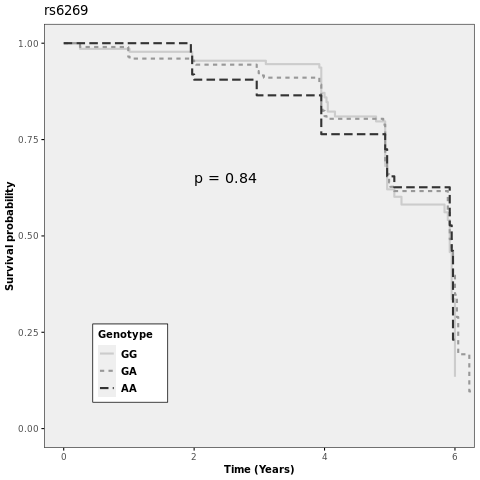

In [280]:
%%R

surv_object_LIDs_rs6269 <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

fit_rs6269 <- survfit(surv_object_LIDs_rs6269 ~ lids$`chr22:19962429:A:G_G`, data = lids)

rs6269_plot<-ggsurvplot(fit_rs6269,
                        data = lids,
                        pval = TRUE,
                        title="rs6269",
                        linetype = "strata",
                        censor=FALSE,
                        palette = "grey",
                        legend.title = "Genotype   ",
                        pval.coord = c(2, 0.65),
                        legend=c(0.2,0.2),
                        legend.labs = c("GG","GA","AA"),
                        xlab= "Time (Years)",
                        font.x=c(10,"bold","black"),
                        font.y=c(10,"bold","black"),
                        font.caption=c(10,"bold","black"),
                        font.legend = c(10, "bold"), 
                        ggtheme = theme(
                         panel.background = element_rect(fill='#efefef'), #transparent panel bg
                         plot.background = element_rect(fill='transparent', color=NA), #transparent plot bg
                         panel.grid.major = element_blank(), #remove major gridlines
                         panel.grid.minor = element_blank(), #remove minor gridlines
                         legend.background = element_rect(fill='transparent'), #transparent legend bg
                         legend.box.background = element_rect(fill='white'), #transparent legend panel
                         panel.border = element_rect(linetype=1, fill = NA),
                       ))


save(rs6269_plot, file = "rs6269_plot.rdata")
rs6269_plot
#summary(fit_rs6269)

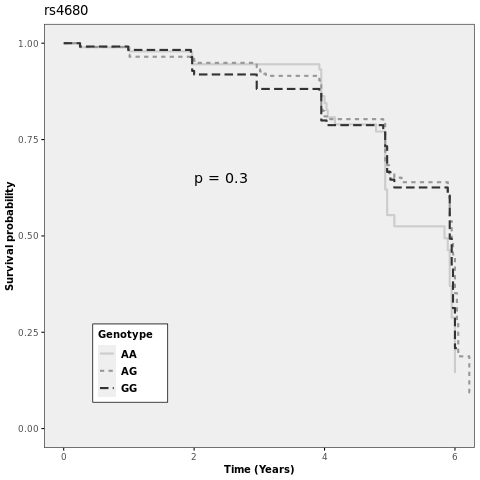

In [266]:
%%R

surv_object_LIDs_rs4680 <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

fit_rs4680 <- survfit(surv_object_LIDs_rs4680 ~ lids$`chr22:19963748:G:A_G`, data = lids)

rs4680_plot<-ggsurvplot(fit_rs4680, 
                        data = lids, 
                        pval = TRUE,
                        title="rs4680",
                        linetype = "strata",
                        censor=FALSE,
                        palette = "grey",
                        legend.title = "Genotype   ",
                        pval.coord = c(2, 0.65),
                        legend=c(0.2,0.2),
                        legend.labs = c("AA","AG","GG"),
                        xlab= "Time (Years)",
                        font.x=c(10,"bold","black"),
                        font.y=c(10,"bold","black"),
                        font.legend = c(10, "bold"), 
                        font.caption=c(10,"bold","black"),
                        ggtheme = theme(
                         panel.background = element_rect(fill='#efefef'), #transparent panel bg
                         plot.background = element_rect(fill='transparent', color=NA), #transparent plot bg
                         panel.grid.major = element_blank(), #remove major gridlines
                         panel.grid.minor = element_blank(), #remove minor gridlines
                         legend.background = element_rect(fill='transparent'), #transparent legend bg
                         legend.box.background = element_rect(fill='white'), #transparent legend panel
                         panel.border = element_rect(linetype=1, fill = NA),
                       ))


save(rs4680_plot, file = "rs4680_plot.rdata")
rs4680_plot


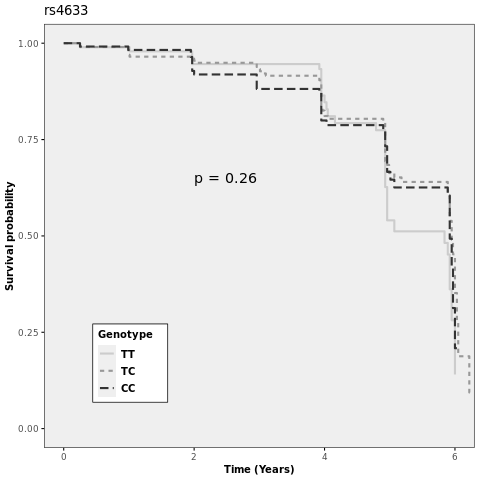

In [267]:
%%R

surv_object_LIDs_rs4633 <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

fit_rs4633 <- survfit(surv_object_LIDs_rs4633 ~ lids$`chr22:19962712:C:T_C`, data = lids)

rs4633_plot<-ggsurvplot(fit_rs4633, 
                        data = lids, 
                        pval = TRUE,
                        title="rs4633",
                        linetype = "strata",
                        censor=FALSE,
                        palette = "grey",
                        legend.title = "Genotype   ",
                        pval.coord = c(2, 0.65),
                        legend=c(0.2,0.2),                        
                        legend.labs = c("TT","TC","CC"),
                        xlab= "Time (Years)",
                        font.x=c(10,"bold","black"),
                        font.legend = c(10, "bold"), 
                        font.y=c(10,"bold","black"),
                        font.caption=c(10,"bold","black"),
                        ggtheme = theme(
                         panel.background = element_rect(fill='#efefef'), #transparent panel bg
                         plot.background = element_rect(fill='transparent', color=NA), #transparent plot bg
                         panel.grid.major = element_blank(), #remove major gridlines
                         panel.grid.minor = element_blank(), #remove minor gridlines
                         legend.background = element_rect(fill='transparent'), #transparent legend bg
                         legend.box.background = element_rect(fill='white'), #transparent legend panel
                         panel.border = element_rect(linetype=1, fill = NA),
                       ))


save(rs4633_plot, file = "rs4633_plot.rdata")
rs4633_plot

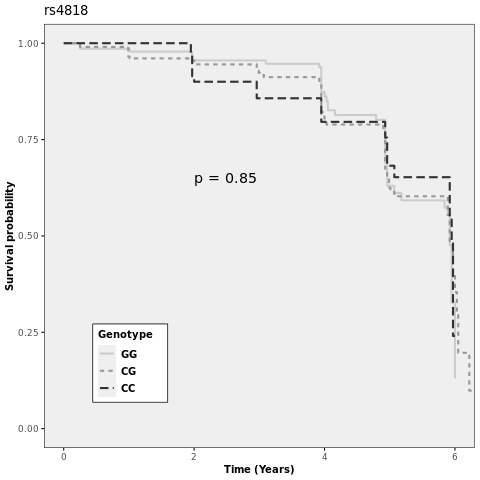

In [290]:
%%R

surv_object_LIDs_rs4818 <- Surv(time = lids$Disease_duration_fromBL, event = lids$dyskinesia_status_at_censoring)

fit_rs4818 <- survfit(surv_object_LIDs_rs4818 ~ lids$`chr22:19963684:C:G_G`, data = lids)

rs4818_plot<-ggsurvplot(fit_rs4818, 
                        data = lids, 
                        pval = TRUE,
                        title="rs4818",
                        linetype = "strata",
                        censor=FALSE,
                        palette = "grey",
                        legend.title = "Genotype   ",
                        pval.coord = c(2, 0.65),
                        legend=c(0.2,0.2),      
                        legend.labs = c("GG","CG","CC"),
                        xlab= "Time (Years)",
                        font.x=c(10,"bold","black"),
                        font.y=c(10,"bold","black"),
                        font.legend = c(10, "bold"), 
                        font.caption=c(10,"bold","black"),
                        ggtheme = theme(
                         panel.background = element_rect(fill='#efefef'), #transparent panel bg
                         plot.background = element_rect(fill='transparent', color=NA), #transparent plot bg
                         panel.grid.major = element_blank(), #remove major gridlines
                         panel.grid.minor = element_blank(), #remove minor gridlines
                         legend.background = element_rect(fill='transparent'), #transparent legend bg
                         legend.box.background = element_rect(fill='white'), #transparent legend panel
                         panel.border = element_rect(linetype=1, fill = NA),
                       ))


save(rs4818_plot, file = "rs4818_plot.rdata")
rs4818_plot

In [277]:
%%R
#install.packages('svglite')
library(svglite)

In [292]:
%%R
all<-cowplot::plot_grid(rs4633_plot$plot,
                        rs6269_plot$plot,
                        rs4680_plot$plot,
                        rs4818_plot$plot,
                        labels=c("A","B","C","D"))
all
ggsave(file="lids.svg", plot=all, width=14, height=16,dpi = 300)
ggsave(file="lids.png", plot=all, width=14, height=16,dpi = 300)

In [85]:
# Copy to bucket
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/*.rdata {WORKSPACE_BUCKET}/COMT_NBA_loop/')

In [86]:
shell_do(f'gsutil -mu {BILLING_PROJECT_ID} cp -r {WORK_DIR}/lids.* {WORKSPACE_BUCKET}/COMT_NBA_loop/')